(3053, 10)
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
3048     8.760437
3049     8.578291
3050     8.025572
3051     7.748016
3052    13.351910
Length: 3053, dtype: float64
               unix                 date   symbol      open      high  \
26    1675209600000  2023-02-01 00:00:00  BTC/USD  23138.09  23800.00   
27    1675123200000  2023-01-31 00:00:00  BTC/USD  22829.24  23303.72   
28    1675036800000  2023-01-30 00:00:00  BTC/USD  23761.08  23809.80   
29    1674950400000  2023-01-29 00:00:00  BTC/USD  23031.37  23953.42   
30    1674864000000  2023-01-28 00:00:00  BTC/USD  23075.34  23185.18   
...             ...                  ...      ...       ...       ...   
3048     1444622400  2015-10-12 04:00:00  BTC/USD    248.98    248.98   
3049     1444536000  2015-10-11 04:00:00  BTC/USD    246.30    249.50   
3050     1444449600  2015-10-10 04:00:00  BTC/USD    245.51    246.30   
3051     1444363200  2015-10-09 

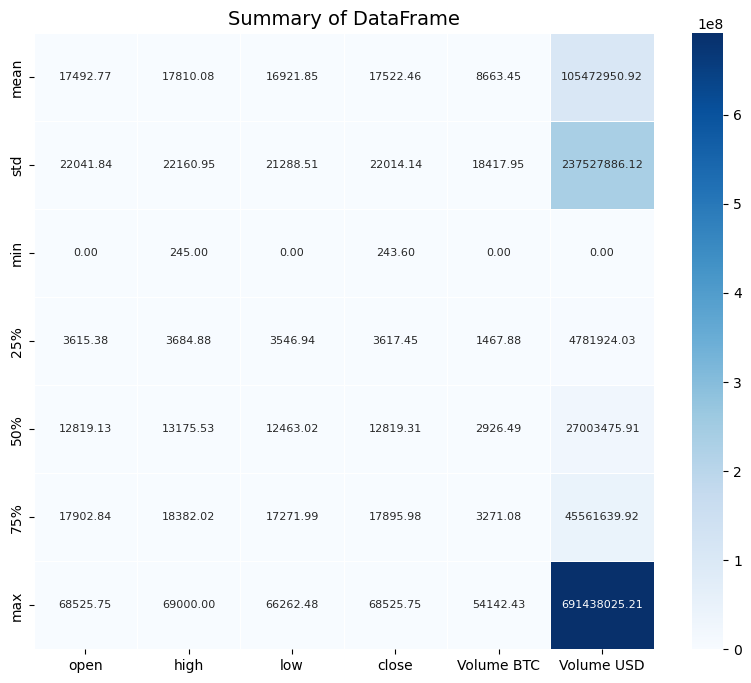

               unix                 date   symbol      open      high  \
26    1675209600000  2023-02-01 00:00:00  BTC/USD  23138.09  23800.00   
27    1675123200000  2023-01-31 00:00:00  BTC/USD  22829.24  23303.72   
28    1675036800000  2023-01-30 00:00:00  BTC/USD  23761.08  23809.80   
29    1674950400000  2023-01-29 00:00:00  BTC/USD  23031.37  23953.42   
30    1674864000000  2023-01-28 00:00:00  BTC/USD  23075.34  23185.18   
...             ...                  ...      ...       ...       ...   
3048     1444622400  2015-10-12 04:00:00  BTC/USD    248.98    248.98   
3049     1444536000  2015-10-11 04:00:00  BTC/USD    246.30    249.50   
3050     1444449600  2015-10-10 04:00:00  BTC/USD    245.51    246.30   
3051     1444363200  2015-10-09 04:00:00  BTC/USD    243.60    249.97   
3052     1444276800  2015-10-08 04:00:00  BTC/USD      0.00    245.00   

           low     close  Volume BTC    Volume USD  price_change  \
26    22801.85  23715.81  462.534137  1.096937e+07     

ModuleNotFoundError: No module named 'tensorflow'

In [6]:


###rnn deeplearning model with 7 factor to compare


##stochastic rsi 0 to 100
import os
import pandas as pd


# Load daily price data into a DataFrame
df = pd.read_csv('Gemini_BTCUSD_d.csv')

#good approach since it captures the volatility of the market more directly and can help avoid issues with differences in price scales across different time periods.
df['price_change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)


print(df.shape)

# Calculate RSI values over 14 days
n = 14
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(n).mean()
avg_loss = loss.rolling(n).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Calculate high-low range over 14 days
high = df['high'].rolling(n).max()
low = df['low'].rolling(n).min()
r = high - low

# Calculate stochastic oscillator values over 14 days
current_close = df['close']
stochastic = (current_close - low) / r * 100

# Calculate Stochastic RSI values over 14 days
k = 14
stochastic_rsi = stochastic.rolling(k).mean()


# Print Stochastic RSI values
print(stochastic_rsi)

#adding to main df 
df['stochastic_rsi'] = stochastic_rsi
df = df.dropna()

print(df)
# Find the maximum and minimum values in the entire DataFrame
df_max = df['stochastic_rsi'].max()
df_min = df['stochastic_rsi'].min()

# Print the maximum and minimum values
print(df_max)
print(df_min)


df2 = df.drop(['unix','price_change', 'stochastic_rsi'], axis=1).describe()
summary = df2.describe().drop('count')

print(summary)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(summary, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Summary of DataFrame', fontsize=14)
plt.show()

##market trend defining 

stoch_rsi_sorted = sorted(stochastic_rsi)
num_overbought = int(len(stoch_rsi_sorted) * 0.2)
num_oversold = int(len(stoch_rsi_sorted) * 0.2)
overbought_threshold = stoch_rsi_sorted[-num_overbought]
oversold_threshold = stoch_rsi_sorted[num_oversold]

# Add market trend column based on Stochastic RSI values
df['market_trend'] = ''
df.loc[df['stochastic_rsi'] > overbought_threshold, 'market_trend'] = 'bullish'
df.loc[df['stochastic_rsi'] < oversold_threshold, 'market_trend'] = 'bearish'
df.loc[(df['stochastic_rsi'] >= oversold_threshold) & (df['stochastic_rsi'] <= overbought_threshold), 'market_trend'] = 'neutral'

print(df)
print(df['market_trend'].value_counts())


##defining model 

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import LSTM, Dense
from keras.layers import GRU
import matplotlib.pyplot as plt


n_steps = 14
# Split the data into input (X) and output (y) variables and defining tuple of X
X = np.array(df['price_change'])


print(X)
print(X.shape)

# Initialize an empty list to hold the sequences
sequences = []

# Move the window forward one unit at a time until the end of the data is reached
for i in range(len(X) - n_steps + 1):
    # Get the sequence of length n_steps starting at index i
    sequence = X[i:i+n_steps]
    # Reshape the sequence to have a third dimension of 1
    sequence = sequence.reshape((n_steps, 1))
    # Append the sequence to the list
    sequences.append(sequence)

# Convert the list of sequences to a numpy array
X_seq = np.array(sequences)

X_seq = X_seq[:-1]
  # remove the last sample to make it the same length as y

# Perform one-hot encoding on the market trend column
enc = OneHotEncoder()
y_onehot = enc.fit_transform(df['market_trend'].values.reshape(-1, 1))

# Extract the one-hot encoded columns as the output variable
y = y_onehot.toarray()
print(y)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y[14:], test_size=0.2, random_state=0)


# Define the RNN model
from keras.layers import Dropout

# Define the RNN model
model = Sequential()
model.add(LSTM(425, input_shape=(n_steps, 1), return_sequences=True))
model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




# Train the model
history = model.fit(X_train, y_train, epochs=45, batch_size=32, validation_data=(X_test, y_test))
                                        ##45


# Save the trained RNN model
model.save('path/to/my_rnn_model2')
# Save the trained RNN model weights
model.save_weights('path/to/my_rnn_weights2')


# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Plot the loss and accuracy curves during training

import plotly.graph_objs as go

# Create traces for loss and accuracy
trace_loss = go.Scatter(x=history.epoch, y=history.history['loss'], name='Training Loss')
trace_val_loss = go.Scatter(x=history.epoch, y=history.history['val_loss'], name='Validation Loss')
trace_acc = go.Scatter(x=history.epoch, y=history.history['accuracy'], name='Training Accuracy')
trace_val_acc = go.Scatter(x=history.epoch, y=history.history['val_accuracy'], name='Validation Accuracy')

# Create layout for the plot
layout = go.Layout(title='Training and Validation Loss and Accuracy',
                   xaxis=dict(title='Epoch'),
                   yaxis=dict(title='Loss / Accuracy'))

# Create figure object and add the traces and layout
fig = go.Figure(data=[trace_loss, trace_val_loss, trace_acc, trace_val_acc], layout=layout)

# Show the plot
fig.show()


plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()






from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from time import time

# Get the predictions for the test data
start_inference = time()
y_pred = model.predict(X_test)
end_inference = time()
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
# Calculate the metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Calculate the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming there are three classes
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate the training time
training_time = history.params['epochs'] * history.params['steps']

# Calculate the inference time
inference_time = end_inference - start_inference

print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1-Score (weighted):", f1)
print("AUC (micro):", roc_auc["micro"])
print("Training Time:", training_time)
print("Inference Time:", inference_time)



from sklearn.metrics import classification_report

# Get the predictions for the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print the classification report
target_names = ['bearish', 'bullish', 'neutral']
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))


(3053, 10)
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
3048     8.760437
3049     8.578291
3050     8.025572
3051     7.748016
3052    13.351910
Length: 3053, dtype: float64
               unix                 date   symbol      open      high  \
26    1675209600000  2023-02-01 00:00:00  BTC/USD  23138.09  23800.00   
27    1675123200000  2023-01-31 00:00:00  BTC/USD  22829.24  23303.72   
28    1675036800000  2023-01-30 00:00:00  BTC/USD  23761.08  23809.80   
29    1674950400000  2023-01-29 00:00:00  BTC/USD  23031.37  23953.42   
30    1674864000000  2023-01-28 00:00:00  BTC/USD  23075.34  23185.18   
...             ...                  ...      ...       ...       ...   
3048     1444622400  2015-10-12 04:00:00  BTC/USD    248.98    248.98   
3049     1444536000  2015-10-11 04:00:00  BTC/USD    246.30    249.50   
3050     1444449600  2015-10-10 04:00:00  BTC/USD    245.51    246.30   
3051     1444363200  2015-10-09 

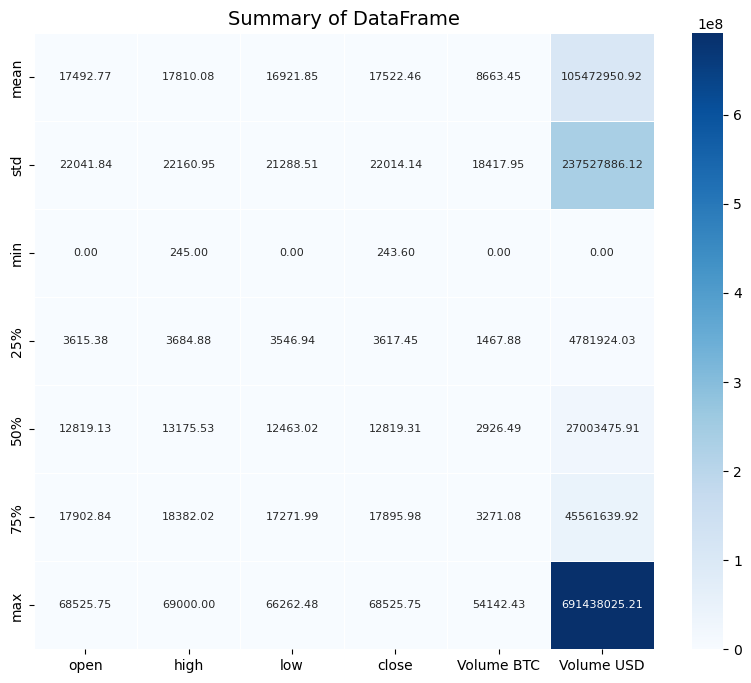

               unix                 date   symbol      open      high  \
26    1675209600000  2023-02-01 00:00:00  BTC/USD  23138.09  23800.00   
27    1675123200000  2023-01-31 00:00:00  BTC/USD  22829.24  23303.72   
28    1675036800000  2023-01-30 00:00:00  BTC/USD  23761.08  23809.80   
29    1674950400000  2023-01-29 00:00:00  BTC/USD  23031.37  23953.42   
30    1674864000000  2023-01-28 00:00:00  BTC/USD  23075.34  23185.18   
...             ...                  ...      ...       ...       ...   
3048     1444622400  2015-10-12 04:00:00  BTC/USD    248.98    248.98   
3049     1444536000  2015-10-11 04:00:00  BTC/USD    246.30    249.50   
3050     1444449600  2015-10-10 04:00:00  BTC/USD    245.51    246.30   
3051     1444363200  2015-10-09 04:00:00  BTC/USD    243.60    249.97   
3052     1444276800  2015-10-08 04:00:00  BTC/USD      0.00    245.00   

           low     close  Volume BTC    Volume USD  price_change  \
26    22801.85  23715.81  462.534137  1.096937e+07     

C:\Users\Moein\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Classification Report:
               precision    recall  f1-score   support

     bearish       0.61      0.60      0.61       112
     bullish       0.63      0.43      0.51       125
     neutral       0.72      0.80      0.75       366

    accuracy                           0.68       603
   macro avg       0.65      0.61      0.62       603
weighted avg       0.68      0.68      0.68       603

Confusion Matrix:
 [[ 67   0  45]
 [  0  54  71]
 [ 42  32 292]]
AUC: 0.7992679480154722
Accuracy: 0.6849087893864013
Precision (weighted): 0.6787289971158528
Recall (weighted): 0.6849087893864013
F1-Score (weighted): 0.676692510242391
Training Time: 0.010068416595458984
Inference Time: 0.11078715324401855
Confusion Matrix:
 [[ 67   0  45]
 [  0  54  71]
 [ 42  32 292]]


C:\Users\Moein\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [7]:
##main KNN with 7 factor to compare 


##stochastic rsi 0 to 100
import os
import pandas as pd

# Load daily price data into a DataFrame
df = pd.read_csv('Gemini_BTCUSD_d.csv')

#good approach since it captures the volatility of the market more directly and can help avoid issues with differences in price scales across different time periods.
df['price_change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)


print(df.shape)

# Calculate RSI values over 14 days
n = 14
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(n).mean()
avg_loss = loss.rolling(n).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Calculate high-low range over 14 days
high = df['high'].rolling(n).max()
low = df['low'].rolling(n).min()
r = high - low

# Calculate stochastic oscillator values over 14 days
current_close = df['close']
stochastic = (current_close - low) / r * 100

# Calculate Stochastic RSI values over 14 days
k = 14
stochastic_rsi = stochastic.rolling(k).mean()


# Print Stochastic RSI values
print(stochastic_rsi)

#adding to main df 
df['stochastic_rsi'] = stochastic_rsi
df = df.dropna()

print(df)
# Find the maximum and minimum values in the entire DataFrame
df_max = df['stochastic_rsi'].max()
df_min = df['stochastic_rsi'].min()

# Print the maximum and minimum values
print(df_max)
print(df_min)


df2 = df.drop(['unix','price_change', 'stochastic_rsi'], axis=1).describe()
summary = df2.describe().drop('count')

print(summary)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(summary, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Summary of DataFrame', fontsize=14)
plt.show()

##market trend defining 

stoch_rsi_sorted = sorted(stochastic_rsi)
num_overbought = int(len(stoch_rsi_sorted) * 0.2)
num_oversold = int(len(stoch_rsi_sorted) * 0.2)
overbought_threshold = stoch_rsi_sorted[-num_overbought]
oversold_threshold = stoch_rsi_sorted[num_oversold]

# Add market trend column based on Stochastic RSI values
df['market_trend'] = ''
df.loc[df['stochastic_rsi'] > overbought_threshold, 'market_trend'] = 'bullish'
df.loc[df['stochastic_rsi'] < oversold_threshold, 'market_trend'] = 'bearish'
df.loc[(df['stochastic_rsi'] >= oversold_threshold) & (df['stochastic_rsi'] <= overbought_threshold), 'market_trend'] = 'neutral'

print(df)
print(df['market_trend'].value_counts())



import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming 'price_changes' is a column in your DataFrame containing daily price changes
window_size = 14

# Create a new DataFrame with rolling windows of size 14 for price changes
X_knn = []
for i in range(window_size, len(df)):
    X_knn.append(df['price_change'].iloc[i-window_size:i].values.tolist())

# Convert the list of lists into a numpy array
X_knn = np.array(X_knn)

# Use the market trend values for the days following the rolling windows as target variables
y_knn = df['market_trend'].iloc[window_size:].values


# Encode the market trend labels to numerical values
label_encoder = LabelEncoder()
y_knn = label_encoder.fit_transform(y_knn)

# Scale the input features
scaler = StandardScaler()
X_knn = scaler.fit_transform(X_knn)

# Split the data into training and testing sets
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=0)

# Train the kNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

# Predict the market trend for the test set
y_pred_knn = knn.predict(X_test_knn)

# Decode the numerical predictions back to the original labels
y_pred_knn_labels = label_encoder.inverse_transform(y_pred_knn)
y_test_knn_labels = label_encoder.inverse_transform(y_test_knn)

# Print the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test_knn_labels, y_pred_knn_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test_knn_labels, y_pred_knn_labels))



y_pred_proba = knn.predict_proba(X_test_knn)
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test_knn, y_pred_proba, multi_class='ovr')
print("AUC:", auc_score)




import time



# Train the kNN model
knn = KNeighborsClassifier(n_neighbors=5)

start_train_time = time.time()
knn.fit(X_train_knn, y_train_knn)
end_train_time = time.time()
training_time = end_train_time - start_train_time

# Predict the market trend for the test set
start_inference_time = time.time()
y_pred_knn = knn.predict(X_test_knn)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

# Decode the numerical predictions back to the original labels
y_pred_knn_labels = label_encoder.inverse_transform(y_pred_knn)
y_test_knn_labels = label_encoder.inverse_transform(y_test_knn)

# Print the classification report and confusion matrix
report = classification_report(y_test_knn_labels, y_pred_knn_labels, output_dict=True)
confusion_mat = confusion_matrix(y_test_knn_labels, y_pred_knn_labels)

accuracy = report['accuracy']
precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_score_weighted = report['weighted avg']['f1-score']

print("Accuracy:", accuracy)
print("Precision (weighted):", precision_weighted)
print("Recall (weighted):", recall_weighted)
print("F1-Score (weighted):", f1_score_weighted)
print("Training Time:", training_time)
print("Inference Time:", inference_time)
print("Confusion Matrix:\n", confusion_mat)












In [9]:
### svm model with 7 factor to compare 

import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Data processing

# Assuming 'price_changes' is a column in your DataFrame containing daily price changes
window_size = 14

# Create a new DataFrame with rolling windows of size 14 for price changes
X_svm = []
for i in range(window_size, len(df)):
    X_svm.append(df['price_change'].iloc[i-window_size:i].values.tolist())

# Convert the list of lists into a numpy array
X_svm = np.array(X_svm)

# Use the market trend values for the days following the rolling windows as target variables
y_svm = df['market_trend'].iloc[window_size:].values


# Encode the market trend labels to numerical values
label_encoder = LabelEncoder()
y_svm = label_encoder.fit_transform(y_svm)

# Scale the input features
scaler = StandardScaler()
X_svm = scaler.fit_transform(X_svm)

# Split the data into training and testing sets
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=0)

#SVM - SVC test rbf kernel
classifier = SVC(C = 2, kernel = 'rbf', gamma=10, decision_function_shape = 'ovr')
classifier.fit(X_train_svm, y_train_svm.ravel())

pre_train = classifier.predict(X_train_svm)
pre_test = classifier.predict(X_test_svm)

print(f"train score, {accuracy_score(y_train_svm, pre_train)}")
print(f"test score, {accuracy_score(y_test_svm, pre_test)}")

#SVM - SVC Linear test
classifier = SVC(C = 2, kernel = 'linear', gamma=10, decision_function_shape = 'ovr', probability = True)
classifier.fit(X_train_svm, y_train_svm.ravel())

pre_train = classifier.predict(X_train_svm)
pre_test = classifier.predict(X_test_svm)

print(f"train score, {accuracy_score(y_train_svm, pre_train)}")
print(f"test score, {accuracy_score(y_test_svm, pre_test)}")

# Based on scores of linear and rbf kernels, we pick the model with linear kernel

y_pred_svm_labels = label_encoder.inverse_transform(pre_test)
y_test_svm_labels = label_encoder.inverse_transform(y_test_svm)

cm = confusion_matrix(y_test_svm, pre_test)
cr = classification_report(y_pred_svm_labels, y_test_svm_labels)

print(f"Classification Report:\n {cr}")
print(f"Confusion Matrix:\n {cm}")

# ROC AUC score calculation
y_probs = classifier.predict_proba(X_test_svm)
roc_auc = roc_auc_score(y_test_svm, y_probs, multi_class='ovr')

pre_train = classifier.predict(X_train_svm)

print(f"train score, {accuracy_score(y_train_svm, pre_train)}")
print(f"test score, {accuracy_score(y_test_svm, pre_test)}")

y_pred_svm_labels = label_encoder.inverse_transform(pre_test)
y_test_svm_labels = label_encoder.inverse_transform(y_test_svm)

cm = confusion_matrix(y_test_svm, pre_test)
cr = classification_report(y_pred_svm_labels, y_test_svm_labels, output_dict=True)

accuracy = cr['accuracy']
precision_weighted = cr['weighted avg']['precision']
recall_weighted = cr['weighted avg']['recall']
f1_score_weighted = cr['weighted avg']['f1-score']

print("Accuracy:", accuracy)
print("Precision (weighted):", precision_weighted)
print("Recall (weighted):", recall_weighted)
print("F1-Score (weighted):", f1_score_weighted)
print("Training Time:", training_time)
print("Inference Time:", inference_time)
print("ROC AUC Score:", roc_auc)
print(f"Classification Report:\n {cr}")
print(f"Confusion Matrix:\n {cm}")




train score, 1.0
test score, 0.6102819237147595
train score, 0.7510373443983402
test score, 0.7728026533996684
Classification Report:
               precision    recall  f1-score   support

     bearish       0.60      0.74      0.66        90
     bullish       0.59      0.80      0.68        93
     neutral       0.89      0.77      0.83       420

    accuracy                           0.77       603
   macro avg       0.69      0.77      0.72       603
weighted avg       0.80      0.77      0.78       603

Confusion Matrix:
 [[ 67   1  44]
 [  0  74  51]
 [ 23  18 325]]
train score, 0.7510373443983402
test score, 0.7728026533996684
Accuracy: 0.7728026533996684
Precision (weighted): 0.7990814351350197
Recall (weighted): 0.7728026533996684
F1-Score (weighted): 0.7797161347441757
Training Time: 0.010068416595458984
Inference Time: 0.11078715324401855
ROC AUC Score: 0.8846461231048798
Classification Report:
 {'bearish': {'precision': 0.5982142857142857, 'recall': 0.7444444444444445, 'f

(3053, 10)
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
3048     8.760437
3049     8.578291
3050     8.025572
3051     7.748016
3052    13.351910
Length: 3053, dtype: float64
               unix                 date   symbol      open      high  \
26    1675209600000  2023-02-01 00:00:00  BTC/USD  23138.09  23800.00   
27    1675123200000  2023-01-31 00:00:00  BTC/USD  22829.24  23303.72   
28    1675036800000  2023-01-30 00:00:00  BTC/USD  23761.08  23809.80   
29    1674950400000  2023-01-29 00:00:00  BTC/USD  23031.37  23953.42   
30    1674864000000  2023-01-28 00:00:00  BTC/USD  23075.34  23185.18   
...             ...                  ...      ...       ...       ...   
3048     1444622400  2015-10-12 04:00:00  BTC/USD    248.98    248.98   
3049     1444536000  2015-10-11 04:00:00  BTC/USD    246.30    249.50   
3050     1444449600  2015-10-10 04:00:00  BTC/USD    245.51    246.30   
3051     1444363200  2015-10-09 

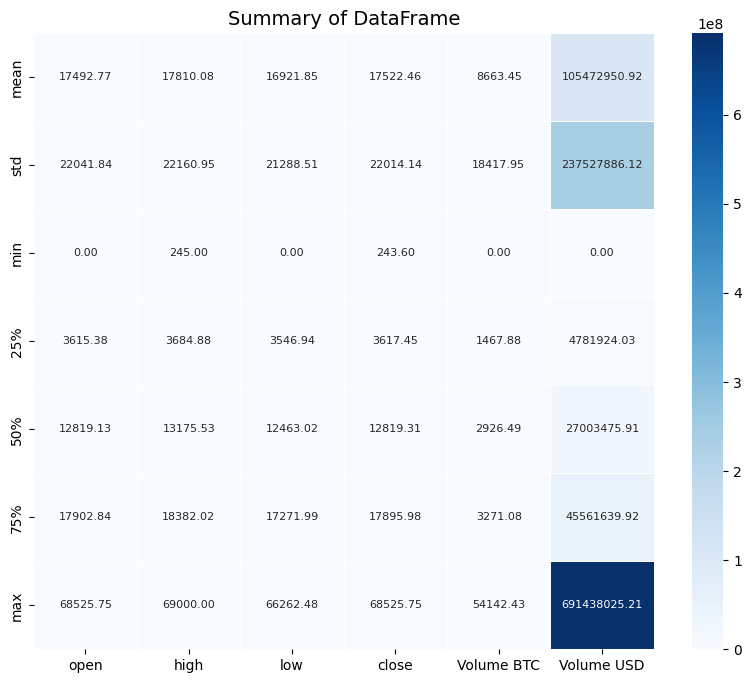

               unix                 date   symbol      open      high  \
26    1675209600000  2023-02-01 00:00:00  BTC/USD  23138.09  23800.00   
27    1675123200000  2023-01-31 00:00:00  BTC/USD  22829.24  23303.72   
28    1675036800000  2023-01-30 00:00:00  BTC/USD  23761.08  23809.80   
29    1674950400000  2023-01-29 00:00:00  BTC/USD  23031.37  23953.42   
30    1674864000000  2023-01-28 00:00:00  BTC/USD  23075.34  23185.18   
...             ...                  ...      ...       ...       ...   
3048     1444622400  2015-10-12 04:00:00  BTC/USD    248.98    248.98   
3049     1444536000  2015-10-11 04:00:00  BTC/USD    246.30    249.50   
3050     1444449600  2015-10-10 04:00:00  BTC/USD    245.51    246.30   
3051     1444363200  2015-10-09 04:00:00  BTC/USD    243.60    249.97   
3052     1444276800  2015-10-08 04:00:00  BTC/USD      0.00    245.00   

           low     close  Volume BTC    Volume USD  price_change  \
26    22801.85  23715.81  462.534137  1.096937e+07     

C:\Users\a\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84057 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:00s
epoch 1  | loss: 1.20722 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:00s
epoch 2  | loss: 1.03037 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:00s
epoch 3  | loss: 0.99612 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:00s
epoch 4  | loss: 0.93881 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:00s
epoch 5  | loss: 0.91766 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:01s
epoch 6  | loss: 0.88097 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:01s
epoch 7  | loss: 0.85579 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:01s
epoch 8  | loss: 0.83395 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:01s
epoch 9  | loss: 0.81985 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:01s
epoch 10 | loss: 0.80501 | train_accuracy: 0.60332 | test_accuracy: 0.60697 |  0:00:01s
epoch 11 | loss: 0.78628 | train

C:\Users\a\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Train accuracy: 0.8120331950207469
Test accuracy: 0.7446102819237148


Classification Report:
              precision    recall  f1-score   support

     bearish       0.75      0.62      0.68       112
     bullish       0.79      0.56      0.65       125
     neutral       0.77      0.89      0.82       366

    accuracy                           0.77       603
   macro avg       0.77      0.69      0.72       603
weighted avg       0.77      0.77      0.76       603

Accuracy: 0.7678275290215588
Precision (weighted): 0.768357124507572
Recall (weighted): 0.7678275290215588
F1-Score (weighted): 0.7603897613702694
Confusion Matrix:
[[ 69   0  43]
 [  0  70  55]
 [ 23  19 324]]
Training Time: 34.62728476524353 seconds
Inference Time: 0.015999317169189453 seconds
AUC: 0.8606921788326432


In [1]:
### tabnet  model with 7 factor to compare 


##stochastic rsi 0 to 100
import os
import pandas as pd
os.chdir('C:/1/1 portablezzz n personals/1 studying/term 2/deep learning/presentation second one')

# Load daily price data into a DataFrame
df = pd.read_csv('Gemini_BTCUSD_d.csv')

#good approach since it captures the volatility of the market more directly and can help avoid issues with differences in price scales across different time periods.
df['price_change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)


print(df.shape)

# Calculate RSI values over 14 days
n = 14
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(n).mean()
avg_loss = loss.rolling(n).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Calculate high-low range over 14 days
high = df['high'].rolling(n).max()
low = df['low'].rolling(n).min()
r = high - low

# Calculate stochastic oscillator values over 14 days
current_close = df['close']
stochastic = (current_close - low) / r * 100

# Calculate Stochastic RSI values over 14 days
k = 14
stochastic_rsi = stochastic.rolling(k).mean()


# Print Stochastic RSI values
print(stochastic_rsi)

#adding to main df 
df['stochastic_rsi'] = stochastic_rsi
df = df.dropna()

print(df)
# Find the maximum and minimum values in the entire DataFrame
df_max = df['stochastic_rsi'].max()
df_min = df['stochastic_rsi'].min()

# Print the maximum and minimum values
print(df_max)
print(df_min)


df2 = df.drop(['unix','price_change', 'stochastic_rsi'], axis=1).describe()
summary = df2.describe().drop('count')

print(summary)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(summary, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Summary of DataFrame', fontsize=14)
plt.show()


##market trend defining 

stoch_rsi_sorted = sorted(stochastic_rsi)
num_overbought = int(len(stoch_rsi_sorted) * 0.2)
num_oversold = int(len(stoch_rsi_sorted) * 0.2)
overbought_threshold = stoch_rsi_sorted[-num_overbought]
oversold_threshold = stoch_rsi_sorted[num_oversold]

# Add market trend column based on Stochastic RSI values
df['market_trend'] = ''
df.loc[df['stochastic_rsi'] > overbought_threshold, 'market_trend'] = 'bullish'
df.loc[df['stochastic_rsi'] < oversold_threshold, 'market_trend'] = 'bearish'
df.loc[(df['stochastic_rsi'] >= oversold_threshold) & (df['stochastic_rsi'] <= overbought_threshold), 'market_trend'] = 'neutral'

print(df)
print(df['market_trend'].value_counts())


import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import plotly.graph_objs as go



# Define the window size
window_size = 14

# Create a rolling window of price changes
price_changes = []
for i in range(window_size, len(df)):
    window = df.iloc[i - window_size:i]['price_change'].values
    price_changes.append(window)

# Convert the list of price changes to a numpy array
X = np.array(price_changes)


# Reshape X to collapse the window size dimension
X = X.reshape(X.shape[0], -1)


# Encode the market trend labels
le = LabelEncoder()
df['market_trend_encoded'] = le.fit_transform(df['market_trend'])
y = df['market_trend_encoded'].values


# Drop the first 14 rows from X and y
y = y[window_size:]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize the TabNet model
tabnet_model = TabNetClassifier(
    n_d=8, n_a=8, n_steps=3,
    gamma=1.3, n_independent=2, n_shared=2,
    cat_idxs=[], cat_dims=[], cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)


from torch.nn.functional import cross_entropy

import time

# Train the TabNet model and time it
start_train_time = time.time()
# Train the TabNet model
tabnet_model.fit(
    X_train.astype(np.float32), y_train,
    eval_set=[(X_train.astype(np.float32), y_train), (X_test.astype(np.float32), y_test)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=200, patience=100,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    loss_fn=torch.nn.CrossEntropyLoss()
)

end_train_time = time.time()
train_time = end_train_time - start_train_time
# Evaluate the model
train_acc = tabnet_model.history['train_accuracy'][-1]
test_acc = tabnet_model.history['test_accuracy'][-1]

print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

import plotly.graph_objs as go

# Create traces for accuracy
trace_train_acc = go.Scatter(x=list(range(len(tabnet_model.history['train_accuracy']))), y=tabnet_model.history['train_accuracy'], name='Training Accuracy')
trace_test_acc = go.Scatter(x=list(range(len(tabnet_model.history['test_accuracy']))), y=tabnet_model.history['test_accuracy'], name='Validation Accuracy')

# Create layout for the accuracy plot
layout_acc = go.Layout(title='Training and Validation Accuracy',
                       xaxis=dict(title='Epoch'),
                       yaxis=dict(title='Accuracy'))

# Create figure object and add the traces and layout for the accuracy plot
fig_acc = go.Figure(data=[trace_train_acc, trace_test_acc], layout=layout_acc)

# Show the accuracy plot
fig_acc.show()


from sklearn.metrics import classification_report

# Get the predicted values for the test set
y_pred = tabnet_model.predict(X_test.astype(np.float32))

# Calculate the classification report
report = classification_report(y_test, y_pred, target_names=le.classes_, digits=2)

print("Classification Report:")
print(report)


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Precision, Recall, F1-Score (weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision (weighted): {precision}")
print(f"Recall (weighted): {recall}")
print(f"F1-Score (weighted): {f1_score}")
print(f"Confusion Matrix:\n{cm}")







# Evaluate the model and time it
start_inference_time = time.time()
y_pred = tabnet_model.predict(X_test.astype(np.float32))
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Training Time: {train_time} seconds")
print(f"Inference Time: {inference_time} seconds")

from sklearn.metrics import roc_auc_score

# Get predicted probabilities for the test set
y_pred_proba = tabnet_model.predict_proba(X_test.astype(np.float32))

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

print(f"AUC: {auc}")
